# Numerical Experiments — Replication Notebook

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import matplotlib.colors as colors
from sklearn.mixture import GaussianMixture


# Analytical illustration of variance reduction via importance sampling

In [12]:
# Sobol g-function in 3 dimensions (a1=1, a2=2, a3=3)
g_sobol_3d  = lambda X: np.prod((np.abs(4*X-2)+np.array([1,2,3]))/(1+np.array([1,2,3])), axis=1)

# Conditional mean m(x1,x2) = E[g(X1,X2,X3) | X1=x1, X2=x2]
m_func      = lambda x1,x2: ((np.abs(4*x1-2)+1)*(np.abs(4*x2-2)+2))/6

# Asymptotic optimal variance integrand S(m) = 4 m^2 ϕ^2 - 3 m^4 
S_from_m    = lambda mv: (9/8)*mv**4   # (for this g-function ϕ^2 = 99/96 m² → simplifies to 9/8 m^4)

# Asymptotic variance of η̂ under a generic density q
sigma2_opt  = lambda q: np.mean(S_vals/np.maximum(q,1e-12)) - eta_12**2

# ---- Grid over [0,1]² for visualization ----
n = 100
x = np.linspace(0,1,n)
X1, X2 = np.meshgrid(x,x)

# Compute m(x1,x2), m², η{1,2}, q* ∝ m², and S(x1,x2)
m_vals  = m_func(X1,X2)
m2_vals = m_vals**2
eta_12  = m2_vals.mean()      # true value of η_{1,2}
q_star  = m2_vals / eta_12    # optimal density (up to normalization)
S_vals  = S_from_m(m_vals)

# ---- Path interpolation (1–t)p + t q* ----
t_vals = np.linspace(0,1,30)

# Coefficient of variation along the path qt
cv_vals = np.array([np.sqrt(sigma2_opt((1-t)+t*q_star))/eta_12 for t in t_vals])


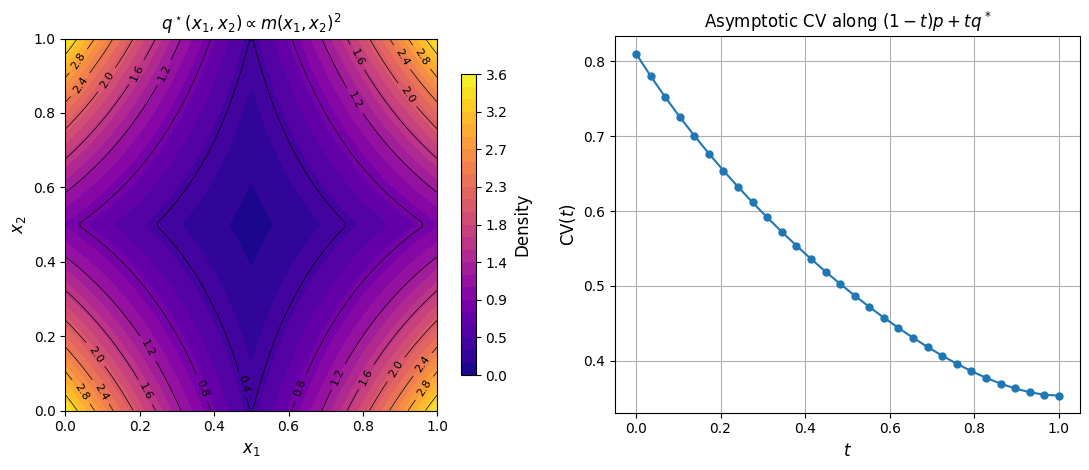

In [13]:
# Create two-panel figure: (1) q* landscape, (2) CV(t)
fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))

# ==== Left plot: heatmap of q_star(x1,x2) using contourf ====
Z = q_star
contour = axes[0].contourf(X1, X2, Z, levels=30, cmap="plasma")  # smooth color map
cbar = fig.colorbar(contour, ax=axes[0], shrink=0.8, format="%.1f")
cbar.set_label("Density", fontsize=12)

# Add contour lines for better visual structure
lines = axes[0].contour(X1, X2, Z, levels=10, colors='k', linewidths=0.5)
axes[0].clabel(lines, fmt="%.1f", inline=True, fontsize=8)

axes[0].set_title(r"$q^\star(x_1,x_2) \propto m(x_1,x_2)^2$", fontsize=12)
axes[0].set_xlabel(r"$x_1$", fontsize=12)
axes[0].set_ylabel(r"$x_2$", fontsize=12)
axes[0].set_aspect("equal")             # keep aspect ratio for square grid
axes[0].tick_params(labelsize=10)

# ==== Right plot: CV(t) along the path (1–t)p + t q* ====
axes[1].plot(t_vals, cv_vals, "-o", markersize=5)
axes[1].set_xlabel(r"$t$", fontsize=12)
axes[1].set_ylabel(r"$\mathrm{CV}(t)$", fontsize=12)
axes[1].set_title("Asymptotic CV along $(1-t)p + t q^*$", fontsize=12)
axes[1].grid(True)
axes[1].tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Parametric optimization

In [14]:
# Parameter grid for Beta(a,b) × Beta(a,b) proposal densities
alpha_vals = np.linspace(0.1, 1, 10)
beta_vals  = np.linspace(0.1, 1, 10)
sigma_grid = np.zeros((len(alpha_vals), len(beta_vals)))

# Density q(x1,x2) = Beta(a,b)(x1) * Beta(a,b)(x2)
def q_beta_grid(a, b, x1g, x2g):
    q = beta.pdf(x1g, a, b) * beta.pdf(x2g, a, b)
    return np.maximum(q, 1e-12)   # avoid division by zero in sigma2_opt

# Compute asymptotic variance for each (a,b) pair
for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        q_beta = q_beta_grid(a, b, X1, X2)
        sigma_grid[i, j] = sigma2_opt(q_beta)

# Retrieve optimal parameters
i_opt, j_opt = np.unravel_index(np.argmin(sigma_grid), sigma_grid.shape)
alpha_opt, beta_opt = alpha_vals[i_opt], beta_vals[j_opt]
sigma_min = sigma_grid[i_opt, j_opt]

print(f"Optimal alpha = {alpha_opt:.3f}, beta = {beta_opt:.3f}")
print(f"Min asymptotic variance = {sigma_min:.4e}")

Optimal alpha = 0.700, beta = 0.700
Min asymptotic variance = 3.3675e-01


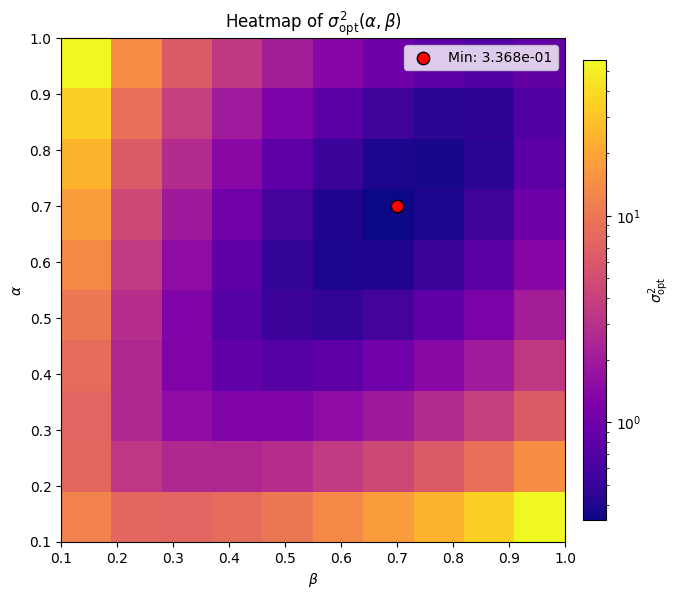

In [15]:
# Heatmap of asymptotic variance σ²_opt(α,β) for Beta(a,b) proposals
fig, ax = plt.subplots(figsize=(7,6))

# Display σ²_opt on a log scale for contrast
c = ax.imshow(sigma_grid, origin="lower",
            extent=[beta_vals.min(), beta_vals.max(),
            alpha_vals.min(), alpha_vals.max()],
            aspect="equal", cmap="plasma", norm=colors.LogNorm())

# Mark the optimal (α,β) pair
ax.scatter(beta_opt, alpha_opt, s=80, c="red", edgecolor="black",label=fr"Min: {sigma_min:.3e}")
ax.legend(loc="upper right")

# Colorbar and axis labels
fig.colorbar(c, ax=ax, shrink=0.9, pad=0.03).set_label(r"$\sigma^2_{\mathrm{opt}}$")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(r"Heatmap of $\sigma^2_{\mathrm{opt}}(\alpha,\beta)$")
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Sampling and estimation example 

In [16]:
# === Logit / logistic transformations ===
# logit(x) maps (0,1) → ℝ ; logistic(z) is the inverse transform
#logit    = lambda x: np.log(np.clip(x,1e-8,1-1e-8)/(1-np.clip(x,1e-8,1-1e-8)))
logit    = lambda x: np.log(x / (1 - x))
logistic = lambda z: 1/(1+np.exp(-z))

# Jacobian of the logit transform: d/dx log(x/(1-x)) = 1/(x(1-x))
jac_logit = lambda x: 1/(x*(1-x))

# === Fit a Gaussian Mixture Model in the logit-transformed space ===
def fit_logit_gmm(x1_fit, x2_fit, k=4):
    # Transform pilot samples to ℝ² via logit
    Z = np.column_stack([logit(x1_fit), logit(x2_fit)])
    # Fit GMM with k components
    gmm = GaussianMixture(k, covariance_type="full", reg_covar=1e-6, random_state=0).fit(Z)
    return gmm

# === Density qθ(x1,x2) over [0,1]² via change of variables ===
def qtheta_pdf(x1, x2, gmm):
    Z = np.column_stack([logit(x1), logit(x2)])            # transform inputs
    return np.exp(gmm.score_samples(Z)) * jac_logit(x1) * jac_logit(x2)  # apply Jacobian

# === Sampling under qθ ===
def sample_qtheta(n, gmm):
    # Sample in latent Z-space, then map back with logistic
    Z,_ = gmm.sample(n)
    X = logistic(Z)
    #X = np.clip(X, 1e-8, 1-1e-8)  # optional safety clipping
    return X[:,0], X[:,1]

# === IS estimator: η̂ = mean( (2Z - mZ) * mZ ) ===
eta_estimator = lambda Z, mZ: np.mean((2*Z - mZ)*mZ)

# === Estimation of η under qθ ===
def eta_under_qtheta(n, gmm):
    # Draw samples under qθ
    X1, X2 = sample_qtheta(n, gmm)
    X3 = np.random.rand(n)                             # third variable drawn from Uniform(0,1)
    Y  = g_sobol_3d(np.column_stack([X1,X2,X3]))       # evaluate the model
    qv = qtheta_pdf(X1, X2, gmm)                       # evaluate qθ(x)
    w  = 1/np.sqrt(qv)                                 # importance weights (square-root)
    Z  = w * Y                                         # transformed outputs
    mZ = w * m_func(X1, X2)                            # transformed conditional mean
    return eta_estimator(Z, mZ)

# ----- 2D Acceptance–Rejection sampling for q* ∝ m(x)² -----
def sample_qstar_2d_AR(n):
    #M = (m_vals**2).max()   # borne L∞ (cohérente avec grille)
    # Conservative upper bound for m(x)^2 (empirically works well)
    M = 10
    out = np.empty((n, 2)); k = 0

    # AR loop until n points are accepted
    while k < n:
        m = n - k
        x = np.random.rand(m, 2)                       # propose from Uniform([0,1]^2)
        f = m_func(x[:,0], x[:,1])**2                  # unnormalized q*(x) = m(x)^2
        u = np.random.rand(m) * M                      # acceptance threshold
        acc = (u <= f)                                 # accept where u <= m(x)^2
        cnt = int(acc.sum())
        if cnt > 0:
            out[k:k+cnt] = x[acc]
            k += cnt

    return out[:,0], out[:,1]

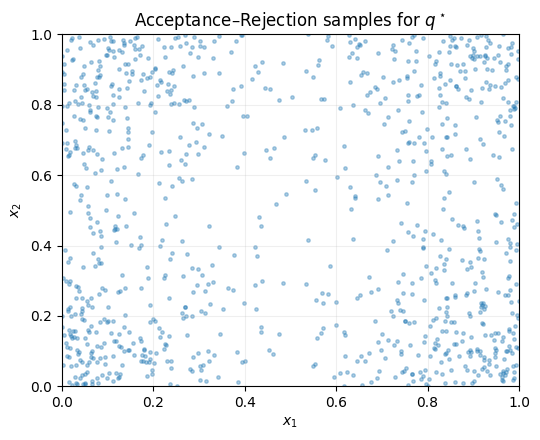

In [17]:
# Number of pilot samples used to learn qθ
n_fit_global = 1000

# Draw samples from q* ∝ m(x)^2 using acceptance–rejection
x1f, x2f = sample_qstar_2d_AR(n_fit_global)

# Fit the logit–GMM on the pilot sample
gmm_global = fit_logit_gmm(x1f, x2f)

# ---- Visualization of the q* samples ----
n_display = min(5000, len(x1f))             # limit to 5000 points for plotting
idx = np.random.choice(len(x1f), size=n_display, replace=False)

plt.figure(figsize=(5.5, 4.5))
plt.scatter(x1f[idx], x2f[idx], s=6, alpha=0.35, color="tab:blue")
plt.title(r"Acceptance–Rejection samples for $q^\star$")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


η_p  (moyenne) = 1.11976, σ = 2.218e-02
η_qθ (moyenne) = 1.12946, σ = 1.072e-02
Réduction de variance ≈ 76.7%


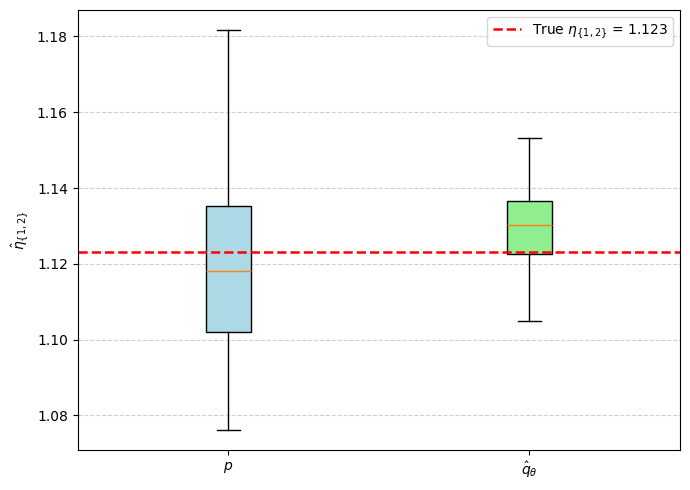

In [18]:
def compare_p_vs_qtheta(n_rep, n):
    """ Compare empirical distributions of η̂ under p and under qθ. """

    eta_p, eta_q = [], []
    for _ in range(n_rep):

        # ---- Sampling under p ----
        # Cost matching: use (n_fit_global + n) samples under p
        Xp = np.random.rand(n + n_fit_global, 3)
        Yp = g_sobol_3d(Xp)
        eta_p.append(eta_estimator(Yp, m_func(Xp[:,0],Xp[:,1])))

        # ---- Sampling under qθ ----
        # Only n samples needed because qθ has already been fitted
        eta_q.append(eta_under_qtheta(n, gmm_global))

    return np.array(eta_p), np.array(eta_q)

# === Run comparison p vs qθ ===
eta_p, eta_q = compare_p_vs_qtheta(n_rep=100, n=1000)

print(f"η_p  (moyenne) = {np.mean(eta_p):.5f}, σ = {np.std(eta_p):.3e}")
print(f"η_qθ (moyenne) = {np.mean(eta_q):.5f}, σ = {np.std(eta_q):.3e}")
print(f"Réduction de variance ≈ {(1 - (np.std(eta_q)/np.std(eta_p))**2)*100:.1f}%")

# === Boxplot of the empirical distributions ===
eta_theoretical = 1.123  # true analytical value

fig, ax = plt.subplots(figsize=(7,5))
bp = ax.boxplot([eta_p, eta_q],
                labels=[r"$p$", r"$\hat{q}_\theta$"],
                patch_artist=True, showfliers=False)

# Colors for the boxplot
for box,c in zip(bp["boxes"], ["lightblue","lightgreen"]):
    box.set_facecolor(c)

# True η line
ax.axhline(eta_theoretical, color="red", lw=1.8, ls="--",
           label=rf"True $\eta_{{\{{1,2\}}}}$ = {eta_theoretical:.3f}")

ax.set_ylabel(r"$\hat{\eta}_{\{1,2\}}$")
ax.grid(axis="y", ls="--", alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

Note. When re-running the boxplot cell, the boxplot may appear slightly more or 
less centered around the true value. This is normal: at each execution, new 
Monte-Carlo samples are drawn under p and under the fixed qθ. Since these samples 
change every time, the empirical mean can fluctuate slightly, which explains the 
small shifts in the boxplot. Over many repetitions, these variations cancel out.

In the following loop, we repeat the *whole* numerical experiment 100 times,
using a different random seed at each repetition.

For each seed, we compute the **mean** of the 100 IS estimates.
Thus, we obtain 100 such means — one per seed.
The final output reports:

* the **mean of these 100 means**, which reflects the global bias across runs,
* the **standard deviation of these 100 means**, which measures *inter-run stability*
  (not the variance of the estimator itself).

This diagnostic verifies that the observed variance reduction does not depend on
a particular lucky or unlucky random seed, and that the whole estimation pipeline
is stable across independent repetitions of the entire procedure. 
The following cell takes around 13 seconds to execute.

In [19]:
vals = []
for seed in range(100):
    np.random.seed(seed)   # different RNG realization for each seed
    # === Re-learn qθ at each seed (full pipeline restart) ===
    x1f, x2f = sample_qstar_2d_AR(n_fit_global)
    gmm_global = fit_logit_gmm(x1f, x2f)
    # === Compute 100 IS estimates under this newly learned qθ ===
    eta_p, eta_q = compare_p_vs_qtheta(n_rep=100, n=1000)
    # store the average IS estimate for this seed
    vals.append(np.mean(eta_q))

mean_val = np.mean(vals)
std_val  = np.std(vals)

print("Mean of means across seeds     = ", mean_val)
print("Std deviation of means = ", std_val)

Mean of means across seeds     =  1.1191502382939
Std deviation of means =  0.010611994441537225


Note. The bias observed here is very small (about 0.4% of the true value). 
This residual bias appears because the learned density qθ is only an approximation 
of the optimal q_opt (due to AR sampling, finite N_fit, and the limited flexibility of 
the K-component GMM). In practice, this effect is negligible and remains below 1% 
across all runs.

A large-n verification in the next cell confirms this point: using 100 repetitions 
with 100,000 samples each gives a mean error of only ≈ 1e−4, showing that the IS 
estimator remains essentially unbiased.

In [20]:
eta_q_large = [eta_under_qtheta(100000, gmm_global) for _ in range(100)]
print(np.mean(eta_q_large) - eta_theoretical)

0.0003707946345379298
